In [63]:
# RFM (Recency, Frequency, Monetary/Value model) 
# XGBoost Version

import datetime
import os
import shap
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [40]:
# Loop individual json files 
# Assumes json files have been downloaded from saved as csv files

data_dir = './data/'
file_list = [file for file in os.listdir(data_dir) if file.endswith('.csv')]
file_list = [file for file in file_list if (file != 'activities.csv') & (file !='total_df.csv')]

In [51]:
def csv_processing(path, file_name):
    """
        Perform cleaning steps and aggregate each data file (i.e. daily statistics) by user. 
        Returns pandas dataframe. 
    """
    
    # Load
    df = pd.read_csv(path + file_name)

    # Cleaning
    df['actorId'] = df['actorId'].str.split('/').str[-1]
    df['verb'] = df['verb'].str.split('/').str[-1]
    df['type'] = df['type'].str.split('/').str[-1]
    df['Time Zone'] = df['Time Zone'].str.split('/').str[-1]
    df['ancestors_depth'] = df['ancestors'].str.split("depth': ").str[-1].str.split("}").str[0].astype(int)
    df['other_depth'] = df['other'].str.split("depth': ").str[-1].str.split("}").str[0]
    df['other_depth'] = df['other_depth'].fillna(0).astype(int)
    df['rating_score'] = df['rating'].fillna(3)
    df['rating_bool'] = np.where(df['rating'].isna(), 0, 1)
    df['response'] = np.where(df['response'].isna(), 0, 1)

    # Filter features
    cols = ['actorId', 'verb', 'type', 'activity', 'ancestors_depth', 'duration', 'completion', 
             'Is Manager', 'Is New Starter', 'Time Zone', 'rating_score', 'rating_bool', 'other_depth', 'response']
    df = df[cols]

    # Aggregate to actorId level
    actor_df = df.groupby('actorId').agg({'activity': 'count',
                                          'verb': 'nunique',
                                          'type': 'nunique',
                                          'ancestors_depth': 'sum',
                                          'duration': 'sum',
                                          'completion': 'sum',
                                          'Is Manager': 'last',
                                          'Is New Starter': 'first',
                                          'Time Zone': 'last',
                                          'rating_score': 'mean',
                                          'rating_bool': 'sum',
                                          'other_depth': 'sum',
                                          'response': 'sum'
                                          }).reset_index()

    actor_df['date'] = file_name.replace('.csv', '')

    return actor_df

In [61]:
def convert_monthly(df):
    """
        Converts previously loaded daily user data into monthly aggregations for model training.
        Includes seasonality calculations. 
        Returns pandas dataframe.
    """
    
    # Aggregation
    df['month'] = pd.to_datetime(df['date']).dt.month
    month_df = df.groupby(['month', 'actorId']).agg({'date': 'max',
                                                     'activity': 'sum',
                                                     'verb': 'sum',
                                                     'type': 'sum',
                                                     'ancestors_depth': 'sum',
                                                     'duration': ['sum', 'std', 'mean', 'max', 'min'],
                                                     'completion': 'sum',
                                                     'Is Manager': 'last',
                                                     'Is New Starter': 'first',
                                                     'Time Zone': 'last',
                                                     'rating_score': 'mean',
                                                     'rating_bool': 'sum',
                                                     'other_depth': 'sum',
                                                     'response': 'sum'
                                                     }).reset_index()
    
    # Cleaning
    month_df.columns = ['month', 'actorId', 'date', 'activity', 'verb', 'type', 'ancestors_depth', 
                        'duration_sum', 'duration_std', 'duration_mean', 'duration_max', 'duration_min', 
                        'completion', 'Is Manager', 'Is New Starter', 'Time Zone', 'rating_score', 
                        'rating_bool', 'other_depth', 'response'] 
    month_df['duration_std'] = month_df['duration_std'].fillna(0)
    month_df['date'] = pd.to_datetime(month_df['date'])
    
    # Seasonality Variables
    month_df['month_sin'] = np.sin((month_df['month'] - 1)*(2.*np.pi/12))
    month_df['month_cos'] = np.cos((month_df['month'] - 1)*(2.*np.pi/12))
    
    
    return month_df

In [64]:
def get_date_range():
    """
        Creates a list of end of month dates. This helps with the creation of model training datasets
          to model monthly as well as ensure only past data is used to make future predictions. 
        Returns list. 
    """
    dates = [datetime.date(2021, x, 1) - datetime.timedelta(days=1) for x in range(8, 13)] 
    dates = dates + [datetime.date(2022, x, 1) - datetime.timedelta(days=1) for x in range(1, 8)]
    dates = [pd.to_datetime(x) for x in dates]
    
    return dates

In [73]:
def create_training_set(df, dates):
    """
        Takes monthly converted data and dates list, and creates a dataset suitable for model training.
        Ensures past data is matched with future target variables, avoiding biased predictions. 
        Returns pandas dataframe. 
    """
    
    data_transform = []

    for x, y in zip(dates[:-1], dates[1:]):
        feature_filter = df['date'] <= x
        label_filter = (df['date'] > x) & (df['date'] <= y)

        features = df.loc[feature_filter]
        labels = df.loc[label_filter, ['actorId', 'completion']]
        
        # Categorical Encoding
        zones = features.groupby('Time Zone')['completion'].mean().to_dict()         
        
        # Feature engineering
        features = features.groupby('actorId').agg({'date': 'max', 
                                                    'activity': 'sum',
                                                    'verb': 'sum',
                                                    'type': 'sum',
                                                    'ancestors_depth': 'sum',
                                                    'duration_sum': 'sum',
                                                    'duration_std': 'mean',
                                                    'duration_mean': 'mean',
                                                    'duration_max': 'max',
                                                    'duration_min': 'min',
                                                    'Is Manager': 'last',
                                                    'Is New Starter': 'last',
                                                    'Time Zone': 'last',
                                                    'rating_score': 'mean',
                                                    'rating_bool': 'sum',
                                                    'other_depth': 'sum',
                                                    'month_sin': 'last',
                                                    'month_cos': 'last'}).reset_index()
        features['recency'] = (x - features['date']).dt.days
        features['Is Manager'] = np.where(features['Is Manager'] == 'Y', 1, 0)
        features['Is New Starter'] = np.where(features['Is New Starter'] == 'Y', 1, 0)
        features['Time Zone'] = features['Time Zone'].map(zones) 
        
        features = features[['actorId', 'recency', 'activity', 'verb', 'type', 'ancestors_depth',
                             'duration_sum', 'duration_std', 'duration_mean', 'duration_max', 'duration_min', 
                             'Is Manager', 'Is New Starter', 'Time Zone', 'rating_score', 'rating_bool',
                             'other_depth', 'month_sin', 'month_cos']]

        # Merge features with t+1 labels
        new_data = pd.merge(left=features,
                            right=labels,
                            how='left',
                            on='actorId')
        new_data['completion'].fillna(0, inplace=True)

        data_transform.append(new_data)

    df_transform = pd.concat(data_transform)
    
    return df_transform

In [66]:
# Load individual date csv's and merge dataframe
data = [csv_processing(data_dir, x) for x in file_list]
df = pd.concat(data)
df.head()

Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
Columns (12,15) have mixed types.Specify dtype option on import or set low_memory=False.


,actorId,activity,verb,type,ancestors_depth,duration,completion,Is Manager,Is New Starter,Time Zone,rating_score,rating_bool,other_depth,response,date
0,+BKJ+UoRTBgHEYyaRNFMmEZTDtlhPMn7A==,15,3,0,8,191584,3.0,Y,N,Sydney,3.0,0,0,0,2021-07-01
1,+L2a3zEmWxYQ==,6,3,2,2,36941,2.0,N,N,Sydney,3.0,0,0,0,2021-07-01
2,+NyLRujuLiWC18B1AifgVVIH0DVSJ88TpGdA==,6,2,0,8,216127,0.0,Y,N,Perth,3.0,0,0,0,2021-07-01
3,+RTyb9OmKVwMcCVQDHIiVgV4KlEPgkk1CA==,2,2,0,1,37,0.0,Y,N,Perth,3.0,0,0,0,2021-07-01
4,+X0MyKnIFWAxRR9oNE0bbz5AE2A+s3gENg==,5,4,1,1,12842,2.0,N,N,Brisbane,3.0,0,0,0,2021-07-01


In [67]:
# Convert to monthly data
dates = get_date_range()
month_df = convert_monthly(df)

In [74]:
# Create training set 
model_dataset = create_training_set(month_df, dates)

In [75]:
# Train/Test split
cols = [x for x in model_dataset.columns if (x != 'completion') & (x != 'actorId')]
X = model_dataset[cols]
y = model_dataset[['completion']].values.reshape(-1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
# Scale data for improved modeling
norm = StandardScaler().fit(X_train)
X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

In [77]:
# Convert data to XGBoost format to improve training speeds.  
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest =  xgb.DMatrix(data=X_test, label=y_test)

In [92]:
# Train model
xg_params = {'objective': 'reg:squarederror',
             'booster': 'gbtree',
             'learning_rate': 0.1,
             'max_depth': 6, 
             'eval_metric': 'rmse',
             'seed': 42}
xg_fit = xgb.train(xg_params, dtrain, num_boost_round=200)

[00:32:55] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [93]:
# Evaluation
preds_train = xg_fit.predict(dtrain)
preds_test = xg_fit.predict(dtest)

train_rmse = mean_squared_error(y_train, preds_train) ** 0.5
test_rmse = mean_squared_error(y_test, preds_test) ** 0.5

print(f"Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

Train RMSE: 15.298188093497359, Test RMSE: 16.203149060013647


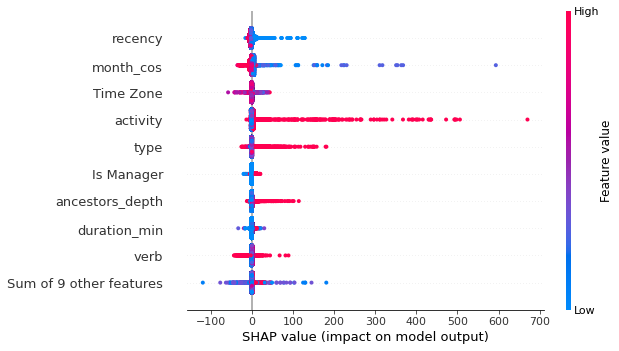

In [103]:
# Feature importance
explainer = shap.Explainer(xg_fit)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

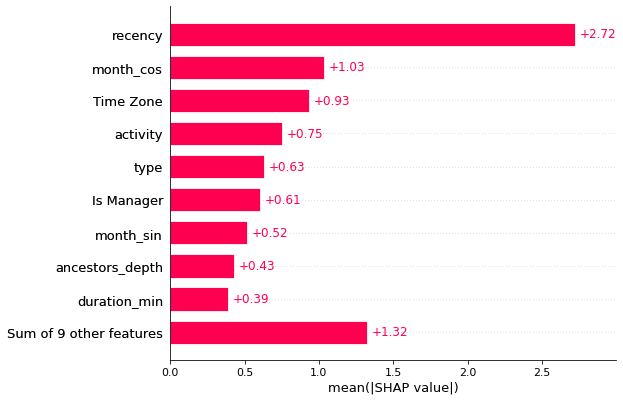

In [104]:
shap.plots.bar(shap_values)